
## Обратная связь: техническое



#### ❓ Непонятно почему градиент в вершине равен 1. Непонятно что это за градиент (чего по чему).


Вспомним, как у нас выглядит шаг обучения:

In [ ]:
# Forward Pass
predictions = model(inputs)

# Compute Loss
# tensor( 1.67435 )
loss_value = criterion(predictions, labels)

# Backward pass
loss_value.backward() # loss_value.grad is assumed to be 1

# Optimization Step
optimizer.step()

Можно воспринимать эту единицу как инициализация размера шага оптимизации.
Проблема в том, что без этой единицы мы не можем посчитать градиенты - этого требует `chain rule`.

**Связь `loss.grad = 1` с `learning_rate`**

🤔 Почему сначала не умножить лосс на `learning_rate` и после этого сделать `backward`?

**1)** В этом случае значения градиентов будут на порядки меньше и может уменьшить точность вычислений.

**2)** Вообще говоря, это допустимо и в случае с `SGD` оптимизатором это было бы эквивалентно нашему изначальному алгоритму:
* считаем градиенты
* умножаем градиенты по параметрам на `lerning_rate`
* делаем шаг обновления

НО! С другими оптимизаторами такой трюк не будет эквивалентен изменению шага оптимизации.



## Обратная связь: лирическое

* Не хватило времени, не успел задать вопросы
* Эффективнее было бы до семинара и лекции самостоятельно изучать материал, а на парах уже разбирать вопросы

**Просьба:** Задавайте, записывайте вопросы, оставляйте их в форме обратной связи или лучше даже скидывайте в чат или можете подойти после занятия, задать их голосом

---

Спасибо, что оставляете обратную связь!


# Вспоминаем прошлое занятие

### Зачем переопределялись операции сложения/умножения на семинаре?


In [ ]:
# Как можно было обойтись без переопределения __magic__ методов класса?

class Value():
    def __init__(self, data, inputs=(), name=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self.inputs = set(inputs)

    def add(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, inputs=(self, other), name='+')

        def _backward():
            self.grad += out.grad * 1
            other.grad += out.grad * 1

        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v.inputs:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1
        for v in reversed(topo):
            v._backward()

value1 = Value(1)
value2 = Value(2)
sumValues = value1.add(value2) # функциональная запись - тоже допустимо и можно, в теории так работать, но не очень удобно
print("sumValues.data", sumValues.data)
sumValues.backward()

print("value1.grad", value1.grad)
print("value2.grad", value2.grad)

sumValues.data 3
value1.grad 1
value2.grad 1


### Идейно пройтиcь по коду автограда


Идейно:

1. Мы не хотим считать производные руками
2. Можно автоматизировать вычисление градиентов используя chain rule
3. Для того, чтобы вычислить градиент мы строим граф вычисления нейросети
4. Чтобы посчитать градиент вершины, надо знать нисходящий градиент и входящие аргументы (например, для вычисления градиента умножения)
5. Чтобы правильно вычислить градиенты графа, надо правильно его обойти. В этом нам поможет обратная топологическая сортировка графа. Важно, чтобы при вычислении значения градиента текущей вершины были посчитаны градиенты всех вершин, в которые входит ребро из текущей вершины.

Интуиция по базовым операциям с градиентами:
1. Сложение - распространяет, размножает градиент по входящим ребрам графа
2. Обратное распространение градиента для умножения меняет местами множители


# План семинара


**Pytorch**
* функции активации
* разобраться с Dataset API
* написать базовый Trainer - класс с тренировочным циклом
* Рассмотреть пример простейшей нейросети
* попробовать писать логи tensorboard
* научиться сохранять/доставать чекпоинты

**Блицы**

* блиц по pytorch


**Обзор домашки**

* Activations
* Weight Initialization

# Функции активации

[Non-linear Activations (weighted sum, nonlinearity)](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity)

[Non-linear Activations (other)](https://pytorch.org/docs/stable/nn.html#non-linear-activations-other)


In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

data_t = torch.arange(-5, 5, 0.1)
data_t

tensor([-3.0000e+00, -2.9000e+00, -2.8000e+00, -2.7000e+00, -2.6000e+00,
        -2.5000e+00, -2.4000e+00, -2.3000e+00, -2.2000e+00, -2.1000e+00,
        -2.0000e+00, -1.9000e+00, -1.8000e+00, -1.7000e+00, -1.6000e+00,
        -1.5000e+00, -1.4000e+00, -1.3000e+00, -1.2000e+00, -1.1000e+00,
        -1.0000e+00, -9.0000e-01, -8.0000e-01, -7.0000e-01, -6.0000e-01,
        -5.0000e-01, -4.0000e-01, -3.0000e-01, -2.0000e-01, -1.0000e-01,
        -2.3842e-08,  1.0000e-01,  2.0000e-01,  3.0000e-01,  4.0000e-01,
         5.0000e-01,  6.0000e-01,  7.0000e-01,  8.0000e-01,  9.0000e-01,
         1.0000e+00,  1.1000e+00,  1.2000e+00,  1.3000e+00,  1.4000e+00,
         1.5000e+00,  1.6000e+00,  1.7000e+00,  1.8000e+00,  1.9000e+00,
         2.0000e+00,  2.1000e+00,  2.2000e+00,  2.3000e+00,  2.4000e+00,
         2.5000e+00,  2.6000e+00,  2.7000e+00,  2.8000e+00,  2.9000e+00])

In [ ]:
relu_module = torch.nn.ReLU()
relu_module

ReLU()

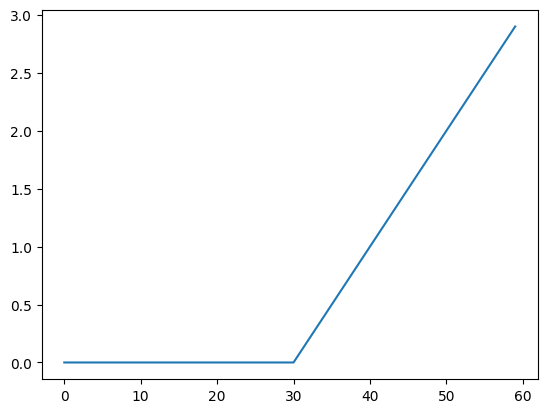

In [ ]:
# relu_module.forward(data_t)
# relu_module(data_t)         # same

plt.plot(relu_module.forward(data_t))

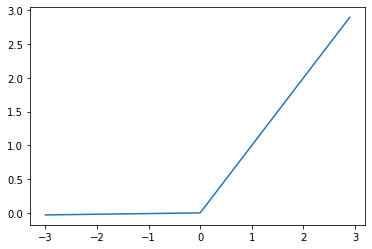

In [ ]:
plt.plot(data_t, torch.nn.LeakyReLU()(data_t))

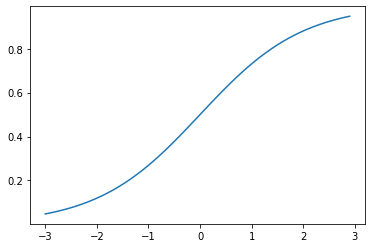

In [ ]:
plt.plot(data_t, torch.nn.Sigmoid()(data_t))

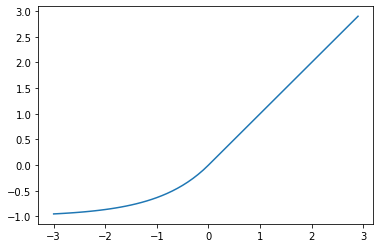

In [ ]:
plt.plot(data_t, torch.nn.ELU()(data_t))

In [4]:
import torch
import torch.nn as nn

sigmoid = nn.Sigmoid()

criterion = nn.MSELoss()

batch_size, features_num = 3, 5
sigmoid_input = nn.Parameter(torch.rand([batch_size, features_num], requires_grad=True) * 5)

sigmoid_out = sigmoid(sigmoid_input)

loss = criterion(sigmoid_out, torch.rand([batch_size, features_num]))
loss.backward()

print("loss", loss)

print("sigmoid_input")
print(sigmoid_input)

print("sigmoid_input.grad")
print(sigmoid_input.grad)

loss tensor(0.2796, grad_fn=<MseLossBackward0>)
sigmoid_input
Parameter containing:
tensor([[1.2073, 3.2473, 0.5732, 4.7202, 3.2083],
        [1.9623, 2.2351, 1.8206, 4.4083, 4.8156],
        [0.8288, 4.4605, 4.6697, 3.7197, 3.5195]], requires_grad=True)
sigmoid_input.grad
tensor([[ 0.0116,  0.0002, -0.0046,  0.0008,  0.0042],
        [ 0.0021,  0.0029,  0.0012,  0.0002,  0.0006],
        [ 0.0195,  0.0004,  0.0009,  0.0030,  0.0021]])


# Практика обучения моделей


In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import wandb

from tqdm.auto import tqdm

## Dataset API


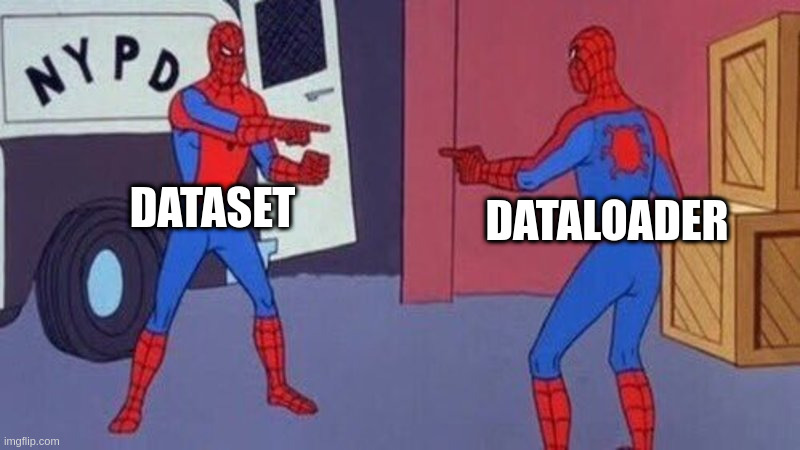


Подготовка данных легко может стать бутылочным горлышком, когда на подготовку очередного батча уходит больше времени, чем на forward+backward проходы по сети.
Проблема усложняется особенностями python: чтобы использовать несколько ядер CPU для подготовки данных надо постараться.

В Pytorch работа с данными строится на двух классах из [torch.utils.data](https://pytorch.org/docs/stable/data.html): `Dataset` и `DataLoader`:

- **`Dataset`** отвечает за подготовку одного примера
- **`DataLoader`** отвечает за выбор примеров, склейку их в один батч и распараллеливание на CPU, поддерживает итерирование.


Для решения задачи обычно пишут кастомные Dataset-классы, для этого нужно написать всего две функции:
- `.__len__(self)` возвращает количество примеров в датасете;
- `.__getitem__(self, i)` возвращает i-тый по счету пример из датасета.

Задачи DataLoader достаточно сложно аккуратно реализовать и лучше использовать готовый. Он довольно гибкий, все основные моменты кастомизируются заданием функций:
```
torch.utils.data.DataLoader(
    dataset,            # экземпляр класса Dataset, из которого надо доставать элементы
    batch_size=1,       # количество примеров в батче
    drop_last=False,    # нужно ли при итерировании выбрасывать неполные батчи? (такое бывает, если число примеров не делится нацело на batch_size
    shuffle=False,      # перемешивать ли элементов
    sampler=None,       # определяет выбор элементов для батча
    batch_sampler=None, # как `sampler`, но возвращает индексы, а не элементы
    num_workers=0,      # на сколько процессов запараллелить подготовку данных
    collate_fn=None,    # функция, которая будет склеивать элементы в батчи

    pin_memory=False,   
    timeout=0,
    worker_init_fn=None,
    multiprocessing_context=None,
    generator=None)
```

Напишите два датасета для работы с `FashionMnist`: один готовит данные как вектора, другой как картинки


**NB: FashionMNIST возвращает картинки в формате PIL.Image.Image, чтобы сделать из него понятный np.array, просто вызовите np.array(PIL_IMAGE)**

100%|██████████| 26.4M/26.4M [00:01<00:00, 13.4MB/s]


Extracting ./tmp/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./tmp/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 198kB/s]


Extracting ./tmp/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./tmp/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.69MB/s]


Extracting ./tmp/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./tmp/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 5.17MB/s]

Extracting ./tmp/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./tmp/FashionMNIST/raw



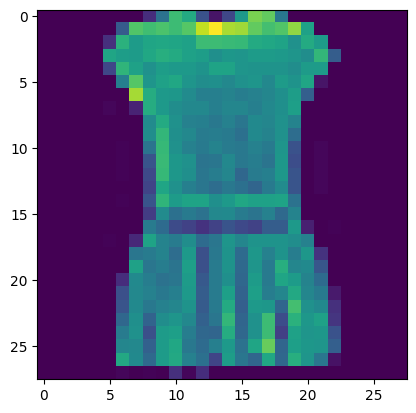

In [6]:
from torchvision.datasets import FashionMNIST
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
fmnist = FashionMNIST("./tmp", train=True, download=True)

plt.imshow(fmnist[3][0])

In [7]:
np.array(fmnist[0][0]).shape

(28, 28)

In [8]:
from collections import namedtuple
from torchvision.datasets import FashionMNIST

class VectorSet:
    def __init__(self, train=True):
        self.data = FashionMNIST("./tmp", train=train, download=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        # сделайте вектор с float32 числами
        sample, label = self.data[item]
        sample = np.array(sample, dtype=np.float32).reshape(-1) / 255
        return dict(
            sample=sample,
            label=label,
        )

vs = VectorSet()
print(vs[0]['sample'].shape)

class ImageSet:
    def __init__(self, train=True):
        self.data = FashionMNIST("./tmp", train=train, download=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        # сделайте одноканальную картинку [1, 28, 28] с float32
        sample, label = self.data[item]
        sample = np.array(sample, dtype=np.float32)[None:, ...] / 255

        return dict(
            sample=sample,
            label=label,
        )

ms = ImageSet()
print(ms[0]['sample'].shape)

(784,)
(28, 28)


In [9]:
# проверьте итерирование, именно его мы используем в train-loop'е
vl = DataLoader(vs, batch_size=4, shuffle=True)
for batch in vl:
    print("batch", type(batch))
    for k, v in batch.items():
        print(k, v.shape)
    break

batch <class 'dict'>
sample torch.Size([4, 784])
label torch.Size([4])


In [10]:
# проверьте итерирование, именно его мы используем в train-loop'е
ml = DataLoader(ms, batch_size=4)
for batch in ml:
    for k, v in batch.items():
        print(k, v.shape)
    break

sample torch.Size([4, 28, 28])
label torch.Size([4])


## Замечания по Dataset/Dataloader

1. Dataset может возвращать что угодно (туплы, словари, whatever) с отдельными числами или массивами (numpy, torch.tensor).
Удобно возвращать словари с читабельными ключами, тогда будет проще разделять логику по компонентам.

2. Имеет смысл поглядеть в [стандартный collate_fn](https://github.com/pytorch/pytorch/blob/master/torch/utils/data/_utils/collate.py#L42): он умеет клеить в батчи и конвертировать в тензора самые разнообразные данные. Это может работать во многих случаях, но неожиданно падать в других. В частности, не сможет поклеить примеры разной длины.


## Trainer


In [20]:
import wandb
wandb.login()
wandb.init(project="03_seminar_dataset_dataloader_trainer")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [17]:
class Trainer:
    def __init__(self, model, optimizer, train_dataset, val_dataset, batch_size=128):
        self.model = model
        self.optimizer = optimizer
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset

        self.batch_size = batch_size

        self.device = 'cpu'
        if torch.cuda.is_available():
            self.device = torch.cuda.current_device()
            self.model = self.model.to(self.device)

        self.global_step = 0
        self.writer = wandb

    def save_checkpoint(self, path):
        torch.save(self.model.state_dict(), path)

    def train(self, num_epochs):

        train_loader = DataLoader(self.train_dataset, shuffle=True, pin_memory=True, batch_size=self.batch_size)

        # валидационный датасет не стоит перемешивать
        val_loader = DataLoader(self.val_dataset, shuffle=False, pin_memory=True, batch_size=self.batch_size)
        best_loss = float('inf')

        for epoch in range(num_epochs):
            model.train()
            for batch in tqdm(train_loader, desc=f"Epoch {epoch}"):
                self.training_step(batch)
                self.global_step += 1

            model.eval()

            val_losses = []
            for batch in tqdm(val_loader):
                loss = self.validation_step(batch)
                val_losses.append(loss.item())

            val_loss = np.mean(val_losses)
            self.writer.log({ "validation/loss": val_loss })
            if val_loss < best_loss:
                self.save_checkpoint("./best_checkpoint.pth")
                best_loss = val_loss


    def training_step(self, batch):
        self.optimizer.zero_grad()

        batch = {k: v.to(self.device) for k, v in batch.items()}
        loss, details = self.model.compute_all(batch)

        loss.backward()
        self.optimizer.step()

        log_metrics = { 'train/' + k: v for k, v in details.items() }
        log_metrics['train/loss'] = loss.item() # Почему важно .item()?

        self.writer.log(log_metrics)

        return

    def validation_step(self, batch):
        batch = {k: v.to(self.device) for k, v in batch.items()}
        loss, details = self.model.compute_all(batch)

        return loss



## MLP

In [18]:
class VeryModel(nn.Module):
    def __init__(self, activation=None):
        super().__init__()

        if activation is None:
            activation = nn.ReLU()

        self.inner = nn.Sequential(
            nn.Linear(784, 100),
            # Dbg(),
            activation,
            nn.Linear(100, 10),
        )

        # nn.Sequential последовательно применяет переданные слои
        # self.linear_1 = nn.Linear(784, 100)
        # self.activation = nn.ReLU(),
        # self.linear_2 = nn.Linear(100, 10),

    def forward(self, x):
        return self.inner(x)
        # return self.inner.forward(x) # def __call__(self, x): return self.forward(x)

        # Эквивалентро применению sequential
        # out = self.linear_1(x)
        # out = self.activation(out)
        # out = self.linear_2(out)
        # return out

    def compute_all(self, batch):  # удобно сделать функцию, в которой вычисляется лосс по пришедшему батчу
        x = batch['sample']    # [ bs, 784 ]
        y = batch['label']     # [ bs ]
        logits = self.inner(x) # [ bs, 10 ]

        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(axis=1) == y).float().mean().cpu().numpy()
        metrics = {
            "train_metrics/acc": acc,
            "train_metrics/loss": loss.detach().item(),
        }
        return loss, metrics

# проверяйте работоспособность сразу
model = VeryModel(activation=nn.Sigmoid())
# model = VeryModel()
opt = optim.SGD(model.parameters(), lr=1e-2)
trainset = VectorSet(train=True)
valset = VectorSet(train=False)

trainer = Trainer(model, opt, trainset, valset, batch_size=128)

In [19]:
trainer.train(5)

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

In [ ]:
class Dbg(nn.Module):
    def forward(self, x):
        print("x.shape", x.shape)
        return x

## Логирование


Возвращаемся к ячейке с wandb.




**Альтернативы wandb**


[Tensorboard](https://www.tensorflow.org/tensorboard) -- это pip-installable web-приложение.

```
tensorboard --logdirs=./some-folder/with/events-files
# зайти на http://localhost:6006
```
<img src="https://www.researchgate.net/publication/335864383/figure/fig1/AS:804107535265792@1568725584130/A-screen-capture-of-the-TensorBoard-output-from-a-model-trained-in-HIPSTER-on-simulated.jpg"/>


## Сохранение-загрузка тензоров и моделек

Нам часто бывает необходимо сохранить/загрузить веса модели в файл на диске.
Распространенное название для этого -- checkpoint.

У торчевых моделей (наследников torch.nn.Module) и оптимизаторов (наследников torch.optim.Optimizer) есть методы для получения и загрузки состояний:

`.state_dict()` возвращает словарь (или почти словарь) с весами

`.load_state_dict(some_dict)` загружает веса из словаря в модельку

Для сохранения/загрузки словарей с тензорами в файлы есть простые функции `torch.save(some_dict, path)` и `torch.load(path)`. Сравните с использованием pickle или json!

**NB: В DL термином checkpointing называют так же метод бекпропа, позволяющий экономить память ценой дополнительных вычислений (https://pytorch.org/docs/stable/checkpoint.html#torch-utils-checkpoint).**

In [ ]:
some_model = nn.Sequential(nn.Linear(10, 10))
print(some_model.state_dict())

opt = optim.Adam(some_model.parameters())
print(opt.state_dict())

torch.save({"model_stuff": some_model.state_dict(), "opt_stuff": opt.state_dict()}, "./that.is.it")

OrderedDict([('0.weight', tensor([[-0.0664, -0.1143,  0.0927,  0.2251, -0.1066,  0.0699,  0.0839,  0.1290,
          0.2634, -0.1207],
        [-0.0667, -0.0684,  0.2839, -0.1812, -0.0663, -0.2177, -0.1561,  0.2530,
         -0.1258,  0.0492],
        [ 0.0277, -0.1238,  0.0233, -0.1850, -0.3061,  0.1397,  0.0905,  0.0550,
         -0.1700, -0.3050],
        [ 0.2981, -0.0113,  0.1828,  0.2367,  0.2410,  0.2082, -0.1709, -0.2723,
         -0.0275,  0.2663],
        [ 0.0250,  0.0213, -0.2093,  0.1383,  0.0041,  0.0610, -0.0874, -0.2920,
         -0.1293, -0.2178],
        [-0.2060,  0.3007, -0.1237, -0.0175, -0.2875,  0.0112, -0.1040, -0.0917,
         -0.1510,  0.0197],
        [ 0.2770,  0.2413, -0.0847,  0.2721, -0.2573, -0.1065, -0.2707, -0.1601,
          0.1047, -0.2812],
        [-0.0505, -0.2201, -0.1225, -0.1742, -0.2167,  0.1323, -0.2703,  0.1405,
         -0.1572, -0.2330],
        [ 0.2996,  0.3131,  0.2423, -0.0556, -0.1100,  0.0063,  0.2777, -0.1559,
          0.0465,  0.

In [ ]:
torch.load("./state.pth")

{'model_stuff': OrderedDict([('0.weight',
               tensor([[-0.0664, -0.1143,  0.0927,  0.2251, -0.1066,  0.0699,  0.0839,  0.1290,
                         0.2634, -0.1207],
                       [-0.0667, -0.0684,  0.2839, -0.1812, -0.0663, -0.2177, -0.1561,  0.2530,
                        -0.1258,  0.0492],
                       [ 0.0277, -0.1238,  0.0233, -0.1850, -0.3061,  0.1397,  0.0905,  0.0550,
                        -0.1700, -0.3050],
                       [ 0.2981, -0.0113,  0.1828,  0.2367,  0.2410,  0.2082, -0.1709, -0.2723,
                        -0.0275,  0.2663],
                       [ 0.0250,  0.0213, -0.2093,  0.1383,  0.0041,  0.0610, -0.0874, -0.2920,
                        -0.1293, -0.2178],
                       [-0.2060,  0.3007, -0.1237, -0.0175, -0.2875,  0.0112, -0.1040, -0.0917,
                        -0.1510,  0.0197],
                       [ 0.2770,  0.2413, -0.0847,  0.2721, -0.2573, -0.1065, -0.2707, -0.1601,
                         0.1

# Блиц по `Pytorch`

### Какие базовые абстракции можно выделить при обучении нейросети?

<!--
* датасет+dataloader
* модель (сама нейросеть)
* оптимизатор
* trainer -- класс, который отвечает за то, как именно должна обучаться модель

ЗЫ можно выделить и больше абстракций
 -->

### Что нужно сохранять для того, чтобы сохранить текущее состояние обучения/модели?

<!-- На саммо деле ответ уже есть в вопросе -- сохраняем `state_dict` для модели и для оптимизатора -->


### Зачем нужно сохранять текущее состояние модели?

<!--
Во-первых, если ничего не сохранить, то никак нельзя будет применить в будущем обученную сеть и после завершения процесса обученные веса просто выгрузятся из памяти и все.

Кроме финального сохранения весов может иметь смысл анализ промежуточных состояний сети - мы хотим знать, что происходит с весами в процессе обучения нейросети?
 -->


### Когда нужно сохранять состояние модели/оптимизатора?

<!--

Вообще говоря, зависит от конкретной задачи, датасета и цели.

Есть разные стратегии сохраннения чекпоинтов:
* можно сохранять чекпоинты в конце каждой эпохи
* можно сохранять N последних чекпоинта
* можно сохранять N лучших чекпоинтов (по метрике или лоссу)
* можно сохранять чекпоинты через k шагов обновления (если в эпохе очень много шагов)

 -->


### Чем отличается Dataset от Dataloader?
<!--
- `Dataset` отвечает за подготовку одного примера
- `DataLoader` отвечает за выбор примеров, склейку их в один батч и распараллеливание на CPU, поддерживает итерирование.
-->

### Зачем нужна `collate_fn`?

<!-- Функция, которая будет склеивать примеры в батчи -->

## Расставьте этапы обучения модели в правильном порядке

* получение примеров для обучения из датасета (`Dataset`)
* склеивание примеров объектов из датасета в батчи (`Dataloader`)
* обновление весов сети
* backward pass
* forward pass + вычисление лосса
* обнуление градиентов `model.zero_grad()`
* сохранение чекпоинта

<!--

Правильный порядок:

* получение примеров для обучения из датасета
* склеивание примеров объектов из датасета в батчи
* обнуление градиентов `model.zero_grad()`
* forward pass + вычисление лосса
* backward pass
* обновление весов сети
* [например, в конце эпохи] сохранение чекпоинта

 -->

### Почему при логировании лосса важно сделать `loss.item()`?

<!-- Чтобы не было утечки памяти. Дело в том, что логгер хранит переданные значения в оперативной памяти. А к переменной `loss` привязан весь граф вычислений (в том числе, значения активаций с промежуточных слоев - вспоминаем прошлый семинар) -->


# Блиц по функциям активации

### Что вы запомнили про ф-и активации?


### Можно ли ставить ф-ии активации после последнего линейного слоя в MLP?

<!--
В теории можно, но в общем случае не рекомендуется.
Могут хуже течь градиенты, проблема dead neurons.

Важно понимать масштаб и диапозон данных, с которыми работает сеть на каждом этапе. Иногда выход из сети может ожидаться в диапозоне [-1, 1]. Иногда [0, 1]. Иногда нет никаких ограничений.

Чаще всего выход сети - это логиты. Которые мы потом преобразуем в вероятности через SoftMax.
 -->


# Блиц по инициализации

### Если инициализировать все веса нейросети нулями, то она не будет обучаться?

### Если не инициализировать веса нейросети, она не будет обучаться?

### Если инициализировать веса нейросети значениями > 1, она не будет обучаться?

### Если инициализировать веса нейросети значениями < 1, она не будет обучаться?

# Обзор домашки

Инвайты на домашку в закрепе чатике

<!--
https://github.com/fintech-dl-hse/hw-activations
https://github.com/fintech-dl-hse/hw-weight-init
-->

#### Pytorch inplace/outplace operations

По умолчанию любая операция и преобразование с тензорами должна возвращать копию тензора.

Но в торче для многих преобразований есть inplace модификация (с подчеркиванием на конце: `add_`, `mul_`, `exp_`, `fill_`)


In [ ]:
import torch

a = torch.randn(5)
b = torch.randn(5)

c = a + b # returns new tensor object
assert id(c) != id(a) and id(c) != id(b)

d = a.add_(b) # inplace add operation in `a` tensor memory

assert id(a) == id(d)
assert (d == a).all()

Это правило касается не только обычных операций с тензорами, но всех модулей (в том числе слои активаций).

inplace операций лучше избегать, если вы точно не уверены, что они вам нужны. Их плюс в том, что такие операции экономят память. Но из минусов можно в какой-то момент получить сломанный граф градиентов (если тензор, который был модифицирован inplace до этой модификации использовался для какой-либо операции, по которой мы хотим считать градиент)

Операция записи по индексам в тензор делается inplace.



In [ ]:
mytensor = torch.rand([10,10])
mask = torch.zeros_like(mytensor).bool() # configure boolean mask

mytensor[mask] = 0 # inplace operation

Поэтому если мы хотим сделать такое в нашем модуле, перед такой операцией надо явно создать клон тензора.

Когда не нужно явно клонировать тензор? В 99% случаев не нужно Для сигмоиды явно клонировать значение тензора не нужно, потому что `torch.exp(...)` и так возвращает новый тензор и не используются inplace операции